<class 'pandas.core.frame.DataFrame'>
Index: 9986 entries, 0 to 11014
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             9986 non-null   object 
 1   Age                         9986 non-null   float64
 2   AnnualIncome                9986 non-null   float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                9986 non-null   float64
 6   MaritalStatus               9986 non-null   object 
 7   NumberOfDependents          9986 non-null   float64
 8   HomeOwnershipStatus         9986 non-null   object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   9986 non-null   float64
 11  NumberOfOpenCreditLines     9986 non-null   float64
 12  NumberOfCreditInquiries     9986 non-null   float64
 13  DebtToIncomeRatio           9986 non-

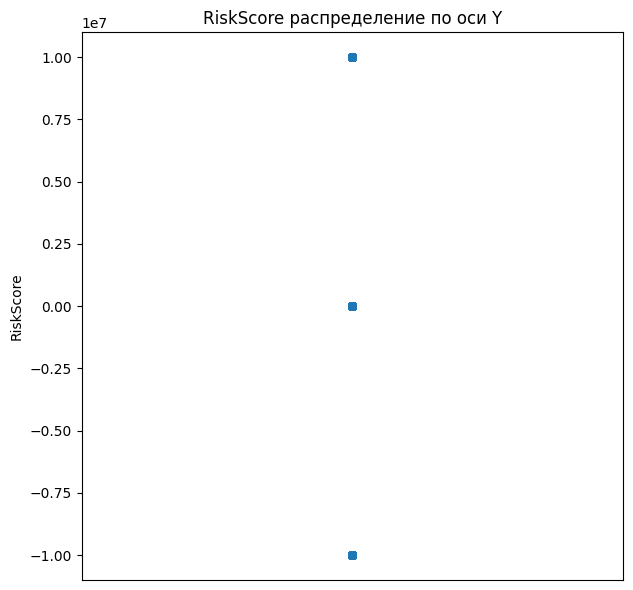

In [474]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/MMVlasko/ml/refs/heads/main/train.csv").dropna()

test_df = pd.read_csv("https://raw.githubusercontent.com/MMVlasko/ml/refs/heads/main/test.csv").dropna(how='all').drop(columns=['ID'])

df.info()


import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x=np.zeros(len(df)), y=df['RiskScore'], alpha=0.6, s=30)
plt.ylabel('RiskScore')
plt.title('RiskScore распределение по оси Y')
plt.xticks([])
plt.tight_layout()
plt.show()

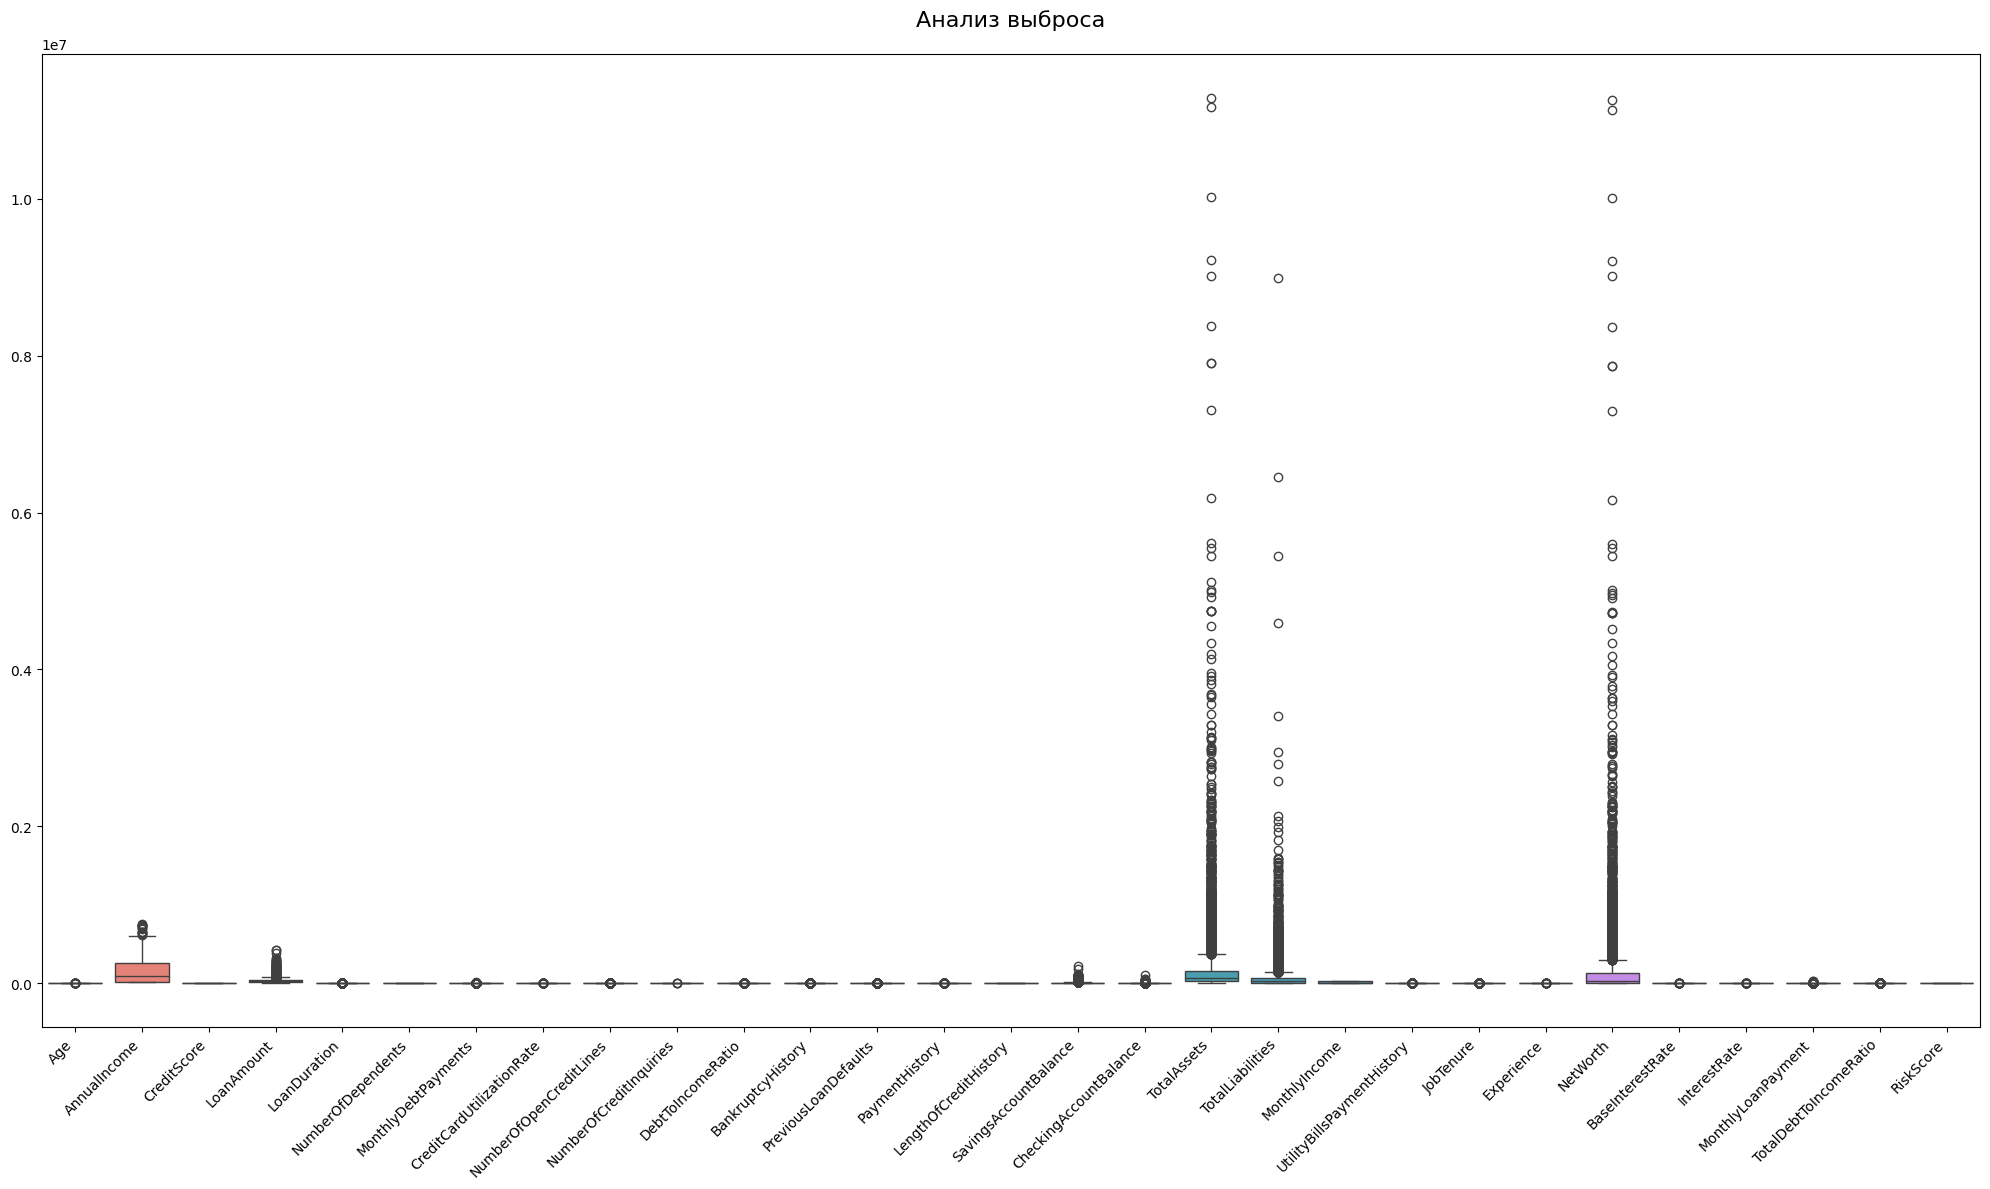

In [475]:
import seaborn as sns

df = df[abs(df['RiskScore']) < 200].drop(columns=['ApplicationDate'])
test_df = test_df.drop(columns=['ApplicationDate'])

plt.figure(figsize=(20, 12))
sns.boxplot(df)
plt.title("Анализ выброса", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [476]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in df.select_dtypes(include=['object']).columns.tolist():
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

for column in test_df.select_dtypes(include=['object']).columns.tolist():
    le = LabelEncoder()
    test_df[column] = le.fit_transform(test_df[column])

cols = test_df.select_dtypes(include=['number']).columns.tolist()
for col in test_df.select_dtypes(include=['number']).columns.tolist():
  df[col + '_cube'] = df[col] ** 3.1
  df[col + '_xx'] = df[col] ** (1/3)
  test_df[col + '_cube'] = test_df[col] ** 3.1
  test_df[col + '_xx'] = test_df[col] ** (1/3)

for ncol1 in range(len(cols) - 5):
  for ncol2 in range(ncol1 + 1, len(cols) - 5):
    col1 = cols[ncol1]
    col2 = cols[ncol2]
    df[col1 + '_' + col2] = df[col1] * df[col2]
    test_df[col1 + '_' + col2] = test_df[col1] * test_df[col2]

def create_financial_stability_features(df):

    # Коэффициент финансовой независимости
    df['FinancialIndependenceRatio'] = (df['NetWorth'] + 1) / (df['TotalLiabilities'] + 1)

    # Покрытие долгов активами
    df['AssetDebtCoverage'] = df['TotalAssets'] / (df['TotalLiabilities'] + 1)

    # "Финансовая подушка" - сбережения относительно дохода
    df['FinancialCushion'] = (df['SavingsAccountBalance'] + df['CheckingAccountBalance']) / \
                            (df['AnnualIncome'] / 12 + 1)

    # Платежная способность (сколько месяцев можно жить на сбережения)
    df['MonthsOfSavings'] = (df['SavingsAccountBalance'] + df['CheckingAccountBalance']) / \
                           (df['MonthlyDebtPayments'] + 1)

    # Риск ликвидности
    df['LiquidityRisk'] = (df['MonthlyDebtPayments'] + df['MonthlyLoanPayment']) / \
                         (df['MonthlyIncome'] + 1)

    # Чистый денежный поток
    df['NetCashFlow'] = df['MonthlyIncome'] - df['MonthlyDebtPayments'] - df['MonthlyLoanPayment']
    df['CashFlowAdequacy'] = df['NetCashFlow'] / (df['MonthlyLoanPayment'] + 1)

    return df

def create_debt_risk_features(df):

    # Общая долговая нагрузка (все долги)
    df['TotalDebtBurden'] = df['MonthlyDebtPayments'] + df['MonthlyLoanPayment']
    df['TotalDebtToIncome'] = df['TotalDebtBurden'] / (df['MonthlyIncome'] + 1)

    # "Долговая ловушка" - отношение долгов к активам
    df['DebtTrapRisk'] = df['TotalLiabilities'] / (df['TotalAssets'] + 1)

    # Риск дефолта на основе кредитного скора и долгов
    df['DefaultRiskScore'] = ((850 - df['CreditScore']) / 850) * df['DebtToIncomeRatio']

    # Нагрузка от нового кредита
    df['NewLoanBurden'] = df['MonthlyLoanPayment'] / (df['MonthlyIncome'] + 1)

    # Соотношение кредита к доходу
    df['LoanToIncomeAnnual'] = df['LoanAmount'] / (df['AnnualIncome'] + 1)

    return df

def add_comprehensive_binning_features(df):

    df_enhanced = df.copy()

    df_enhanced['DebtToIncome_Binned'] = pd.cut(
        df_enhanced['DebtToIncomeRatio'],
        bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=[1, 2, 3, 4, 5]
    ).astype(float)

    # Отношение кредита к доходу
    loan_to_income = df_enhanced['LoanAmount'] / (df_enhanced['AnnualIncome'] + 1)
    df_enhanced['LoanToIncome_Binned'] = pd.cut(
        loan_to_income,
        bins=[0, 0.5, 1.0, 1.5, 2.0, 10],
        labels=[1, 2, 3, 4, 5]
    ).astype(float).fillna(3)

    # Уровень сбережений
    savings_ratio = df_enhanced['SavingsAccountBalance'] / (df_enhanced['AnnualIncome'] + 1)
    df_enhanced['SavingsRatio_Binned'] = pd.cut(
        savings_ratio,
        bins=[0, 0.1, 0.25, 0.5, 1.0, 100],
        labels=[5, 4, 3, 2, 1]
    ).astype(float).fillna(3)

    # Покрытие долгов активами
    asset_coverage = df_enhanced['TotalAssets'] / (df_enhanced['TotalLiabilities'] + 1)
    df_enhanced['AssetCoverage_Binned'] = pd.cut(
        asset_coverage,
        bins=[0, 0.5, 1.0, 2.0, 5.0, 1000],
        labels=[5, 4, 3, 2, 1]
    ).astype(float).fillna(3)

    # Чистая стоимость относительно дохода
    networth_ratio = df_enhanced['NetWorth'] / (df_enhanced['AnnualIncome'] + 1)
    df_enhanced['NetWorthRatio_Binned'] = pd.cut(
        networth_ratio,
        bins=[-1000, 0, 0.5, 1.0, 2.0, 1000],
        labels=[5, 4, 3, 2, 1]
    ).astype(float).fillna(3)

    # Использование кредитного лимита
    df_enhanced['CreditUtilization_Binned'] = pd.cut(
        df_enhanced['CreditCardUtilizationRate'],
        bins=[0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
        labels=[1, 2, 3, 4, 5, 6]
    ).astype(float).fillna(3)

    # Количество кредитных линий
    df_enhanced['CreditLines_Binned'] = pd.cut(
        df_enhanced['NumberOfOpenCreditLines'],
        bins=[0, 1, 3, 5, 7, 10, 100],
        labels=[1, 2, 3, 4, 5, 6]
    ).astype(float).fillna(3)

    # Частота кредитных запросов
    df_enhanced['CreditInquiries_Binned'] = pd.cut(
        df_enhanced['NumberOfCreditInquiries'],
        bins=[-1, 0, 1, 2, 3, 5, 100],
        labels=[1, 2, 3, 4, 5, 6]
    ).astype(float).fillna(2)

    # Длительность кредитной истории
    df_enhanced['CreditHistoryLength_Binned'] = pd.cut(
        df_enhanced['LengthOfCreditHistory'],
        bins=[0, 2, 5, 7, 10, 15, 100],
        labels=[6, 5, 4, 3, 2, 1]
    ).astype(float).fillna(4)

    # Качество платежной истории
    payment_quality = df_enhanced['PaymentHistory'] / (df_enhanced['LengthOfCreditHistory'] + 1)
    df_enhanced['PaymentQuality_Binned'] = pd.cut(
        payment_quality,
        bins=[0, 0.5, 0.7, 0.85, 0.95, 1.0],
        labels=[5, 4, 3, 2, 1]
    ).astype(float).fillna(3)

    return df_enhanced

df = add_comprehensive_binning_features(create_debt_risk_features(create_financial_stability_features(df)))
test_df = add_comprehensive_binning_features(create_debt_risk_features(create_financial_stability_features(test_df)))


def add_quantile_transforms(df, test_df, target='RiskScore'):
    from sklearn.preprocessing import QuantileTransformer
    from sklearn.preprocessing import PowerTransformer

    df_quant = df.copy()
    test_quant = test_df.copy()

    quantile_candidates = [
        'AnnualIncome', 'LoanAmount', 'TotalAssets', 'TotalLiabilities',
        'MonthlyDebtPayments', 'NetWorth'
    ]

    for col in quantile_candidates:
        if col in df.columns:
            qt = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
            df_quant[f'{col}_quantile'] = qt.fit_transform(df[[col]]).flatten()
            test_quant[f'{col}_quantile'] = qt.transform(test_df[[col]]).flatten()

            pt = PowerTransformer(method='yeo-johnson')
            df_quant[f'{col}_yeojohnson'] = pt.fit_transform(df[[col]]).flatten()
            test_quant[f'{col}_yeojohnson'] = pt.transform(test_df[[col]]).flatten()

    return df_quant, test_quant

df, test_df = add_quantile_transforms(df, test_df)


def add_log_transformations(df, test_df):
    df_log = df.copy()
    test_log = test_df.copy()

    for col in cols:
        if (df[col] > 0).all():
            df_log[f'Log_{col}'] = np.log1p(df[col])
            test_log[f'Log_{col}'] = np.log1p(test_df[col])
        else:
            min_val = df[col].min()
            if min_val <= 0:
                shift = abs(min_val) + 1
                df_log[f'Log_{col}'] = np.log1p(df[col] + shift)
                test_log[f'Log_{col}'] = np.log1p(test_df[col] + shift)

    return df_log, test_log

df, test_df = add_log_transformations(df, test_df)
cols_to_cap = df.select_dtypes(include=[np.number]).columns.drop('RiskScore')

for col in cols_to_cap:

    lower_limit = df[col].quantile(0.02)

    upper_limit = df[col].quantile(0.99)

    df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)

    test_df[col] = test_df[col].clip(lower=lower_limit, upper=upper_limit)


/tmp/ipython-input-2137107051.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col1 + '_' + col2] = test_df[col1] * test_df[col2]
/tmp/ipython-input-2137107051.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col1 + '_' + col2] = df[col1] * df[col2]
/tmp/ipython-input-2137107051.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de

In [477]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

correlation_with_target = df.corr()['RiskScore'].abs().sort_values(ascending=False)
print("Корреляция с RiskScore:")
print(correlation_with_target.head(15))

Корреляция с RiskScore:
RiskScore                    1.000000
Log_MonthlyIncome            0.846699
Log_AnnualIncome             0.845739
AnnualIncome_yeojohnson      0.841157
MonthlyIncome_xx             0.831218
AnnualIncome_xx              0.830519
CreditScore                  0.785425
CreditScore_cube             0.784622
CreditScore_MonthlyIncome    0.782298
AnnualIncome_CreditScore     0.782186
NetCashFlow                  0.778771
TotalDebtToIncomeRatio_xx    0.778732
MonthlyIncome                0.770608
CreditScore_xx               0.770588
AnnualIncome                 0.770431
Name: RiskScore, dtype: float64


In [478]:
correlation_with_target = df.corr()['RiskScore'].abs().sort_values(ascending=False)
print("Корреляция с RiskScore:")
print(correlation_with_target.head(15))

low_corr_features = correlation_with_target[correlation_with_target < 0.05].index.tolist()
print(len(low_corr_features))
df = df.drop(columns=low_corr_features)
test_df = test_df.drop(columns=low_corr_features)

Корреляция с RiskScore:
RiskScore                    1.000000
Log_MonthlyIncome            0.846699
Log_AnnualIncome             0.845739
AnnualIncome_yeojohnson      0.841157
MonthlyIncome_xx             0.831218
AnnualIncome_xx              0.830519
CreditScore                  0.785425
CreditScore_cube             0.784622
CreditScore_MonthlyIncome    0.782298
AnnualIncome_CreditScore     0.782186
NetCashFlow                  0.778771
TotalDebtToIncomeRatio_xx    0.778732
MonthlyIncome                0.770608
CreditScore_xx               0.770588
AnnualIncome                 0.770431
Name: RiskScore, dtype: float64
292


In [479]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9787 entries, 0 to 11014
Columns: 254 entries, AnnualIncome to Log_TotalDebtToIncomeRatio
dtypes: float64(253), int64(1)
memory usage: 19.0 MB


In [480]:
from sklearn.preprocessing import StandardScaler

df_standardized = df.copy()

numeric_cols_to_scale = [col for col in df.columns if col != 'RiskScore']

scaler = StandardScaler()
df_standardized[numeric_cols_to_scale] = scaler.fit_transform(df[numeric_cols_to_scale])

df = df_standardized

test_df_standardized = test_df.copy()

scaler = StandardScaler()
numeric_cols_to_scale = [col for col in test_df.columns]
test_df_standardized[numeric_cols_to_scale] = scaler.fit_transform(test_df[numeric_cols_to_scale])

test_df = test_df_standardized

In [481]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_train = df.drop('RiskScore', axis=1)
y_train = df['RiskScore']

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

print("Качество модели на обучающих данных:")
print(f"R² score: {r2_score(y_train, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_train, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred)):.4f}")

residuals = y_train - y_pred


Качество модели на обучающих данных:
R² score: 0.9233
MSE: 22.8465
RMSE: 4.7798


In [482]:
ty_pred = model.predict(test_df)

result = pd.DataFrame({
    'ID': range(len(ty_pred)),
    'RiskScore': ty_pred
})


y_test = pd.read_csv("https://raw.githubusercontent.com/MMVlasko/ml/refs/heads/main/predictions%20(7)%20(2).csv").drop(columns=['ID'])
print(f"R² score: {r2_score(y_test, ty_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, ty_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ty_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, ty_pred):.4f}")

result.to_csv('predictions.csv', index=False)

R² score: 0.9981
MSE: 0.5180
RMSE: 0.7197
MAE: 0.4778


In [483]:
from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>